In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import functools
from matplotlib import pyplot as plt
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

from gantools import utils, plot, data, evaluation, blocks
from gantools.gansystem import GANsystem, UpcaleGANsystem
from gantools.model import WGAN, UpscalePatchWGAN, CosmoWGAN



Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# Setting the forward and backward transform

forward = functools.partial(data.fmap.log_norm_forward, c=8000.0, scale=6.0)
backward = functools.partial(data.fmap.log_norm_backward, c=8000.0, scale=6.0)

# number of sample generated
num_samples = 30

pathmodel = '../saved_results/nbody'
pathsample = '../samples/nbody'

In [4]:
def plot_cubes_paper(cubes, slice_num=None, nx=2, ny=2, bkd=backward, **kwargs):
    def map_to_plot(img):
        return data.fmap.log_forward(bkd(img))
    if len(cubes)<nx*ny:
        raise ValueError("Not enough samples.")
    if slice_num is None:
        slice_num = cubes.shape[1]//2+4
    fig, ax = plt.subplots(nx, ny, sharey=True,figsize=(11/2*nx,10.5/2*ny))
    sn = 0
    for i in range(nx):
        for j in range(ny):
            if nx==1 and ny==1:
                tax = ax
            elif nx==1:
                tax = ax[j]
            elif ny==1:
                tax = ax[i]
            else:
                tax = ax[i,j]
            tax.imshow(map_to_plot(cubes[sn,slice_num]), interpolation='none', **kwargs)
            tax.axis('off')
            sn += 1
    plt.tight_layout()

    return fig

# Generate samples - 32->64->256

## 0->32

In [59]:
name = 'WGAN_ankit_0_to_32_checkpoints'
checkpoint32 = None
checkpoint32 = 60000

pathmodel32 = os.path.join(pathmodel, name)
params_32 = utils.load_params(pathmodel32)


In [60]:
wgan_32 = GANsystem(CosmoWGAN,params_32, name='wgan')

Generator 
--------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 64 outputs
         Size of the variables: (?, 64)
     Reshape to (?, 2, 2, 2, 8)
     0 Inception deconv(1x1,3x3,5x5) layer with 8 channels
         Non linearity applied
         Size of the variables: (?, 4, 4, 4, 24)
     1 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 8, 8, 8, 96)
     2 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 16, 192)
     3 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 192)
     4 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 192)
     5 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity app

In [61]:
gen_samples_32 = wgan_32.generate(N=num_samples, checkpoint=checkpoint32)
gen_samples_32 = np.squeeze(gen_samples_32)

Sampling z
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../saved_results/nbody/WGAN_ankit_0_to_32_checkpoints/wgan-60000
Checkpoint succesfully loaded!


In [62]:
os.makedirs(os.path.join(pathsample,'ankit_0_32/'), exist_ok=True)
utils.save_hdf5(gen_samples_32, os.path.join(pathsample,'ankit_0_32/32_samples_ckpt_latest.h5'))

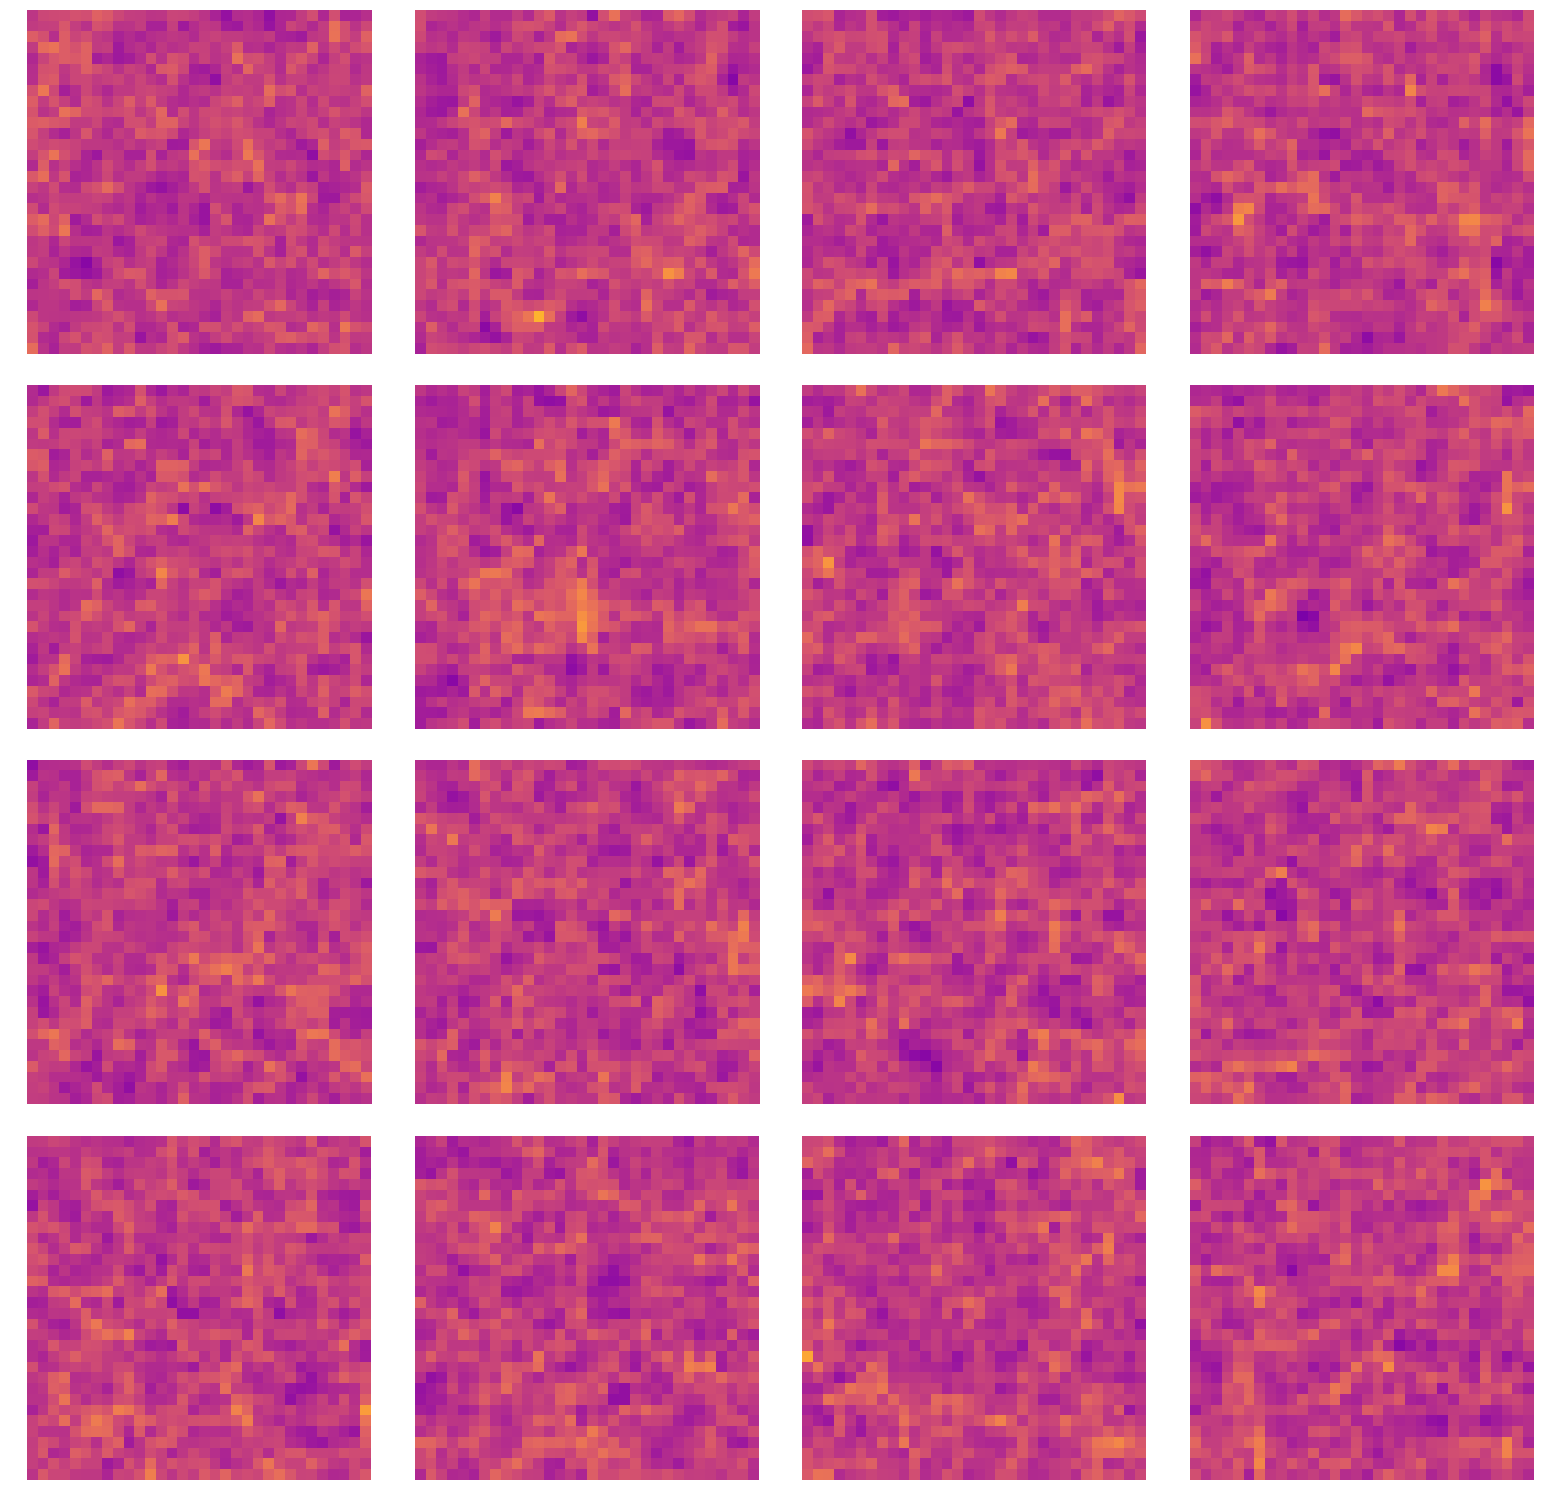

In [63]:
cmin = 0.1
cmax = 2
clim = (cmin, cmax)
plot_cubes_paper(gen_samples_32, cmap=plt.cm.plasma, clim=clim, nx=4, ny=4);

## 32->64

Load fake 32

In [64]:
gen_samples_32 = utils.load_hdf5(os.path.join(pathsample,'ankit_0_32/32_samples_ckpt_latest.h5'))[:num_samples]
print("gen_samples_32 shape=", gen_samples_32.shape)
gen_samples_32 = np.expand_dims(gen_samples_32, axis=4)
print('downsampled shape=', gen_samples_32.shape)

gen_samples_32 shape= (30, 32, 32, 32)
downsampled shape= (30, 32, 32, 32, 1)


In [65]:
name = 'WGAN_ankit_32_to_64_checkpoints'
checkpoint64 = None
class CosmoUpscalePatchWGAN(UpscalePatchWGAN, CosmoWGAN):
    pass

pathmodel64 = os.path.join(pathmodel, name)
params_64 = utils.load_params(pathmodel64)


In [66]:
wgan_64 = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_64)
gen_samples_64 = wgan_64.upscale_image(small=gen_samples_32, checkpoint=checkpoint64)

Generator 
--------------------------------------------------
     The input is of size (?, 32768)
     Reshape to (?, 32, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 32, 9)
     0 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     1 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     2 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Residual connection
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     3 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     4 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Residual connection
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     5 Inception conv(1x1,3x3,5x5) layer wit

Checkpoint successfully loaded!
Total number of patches = 2*2*2 = 8
Current patch: column=1, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=2

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=2

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=2

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=2

Sampling z
Not loading a checkpoint


In [67]:
os.makedirs(os.path.join(pathsample,'ankit_32_64/'), exist_ok=True)
utils.save_hdf5(gen_samples_64, os.path.join(pathsample,'ankit_32_64/64_samples_ckpt_latest.h5'))

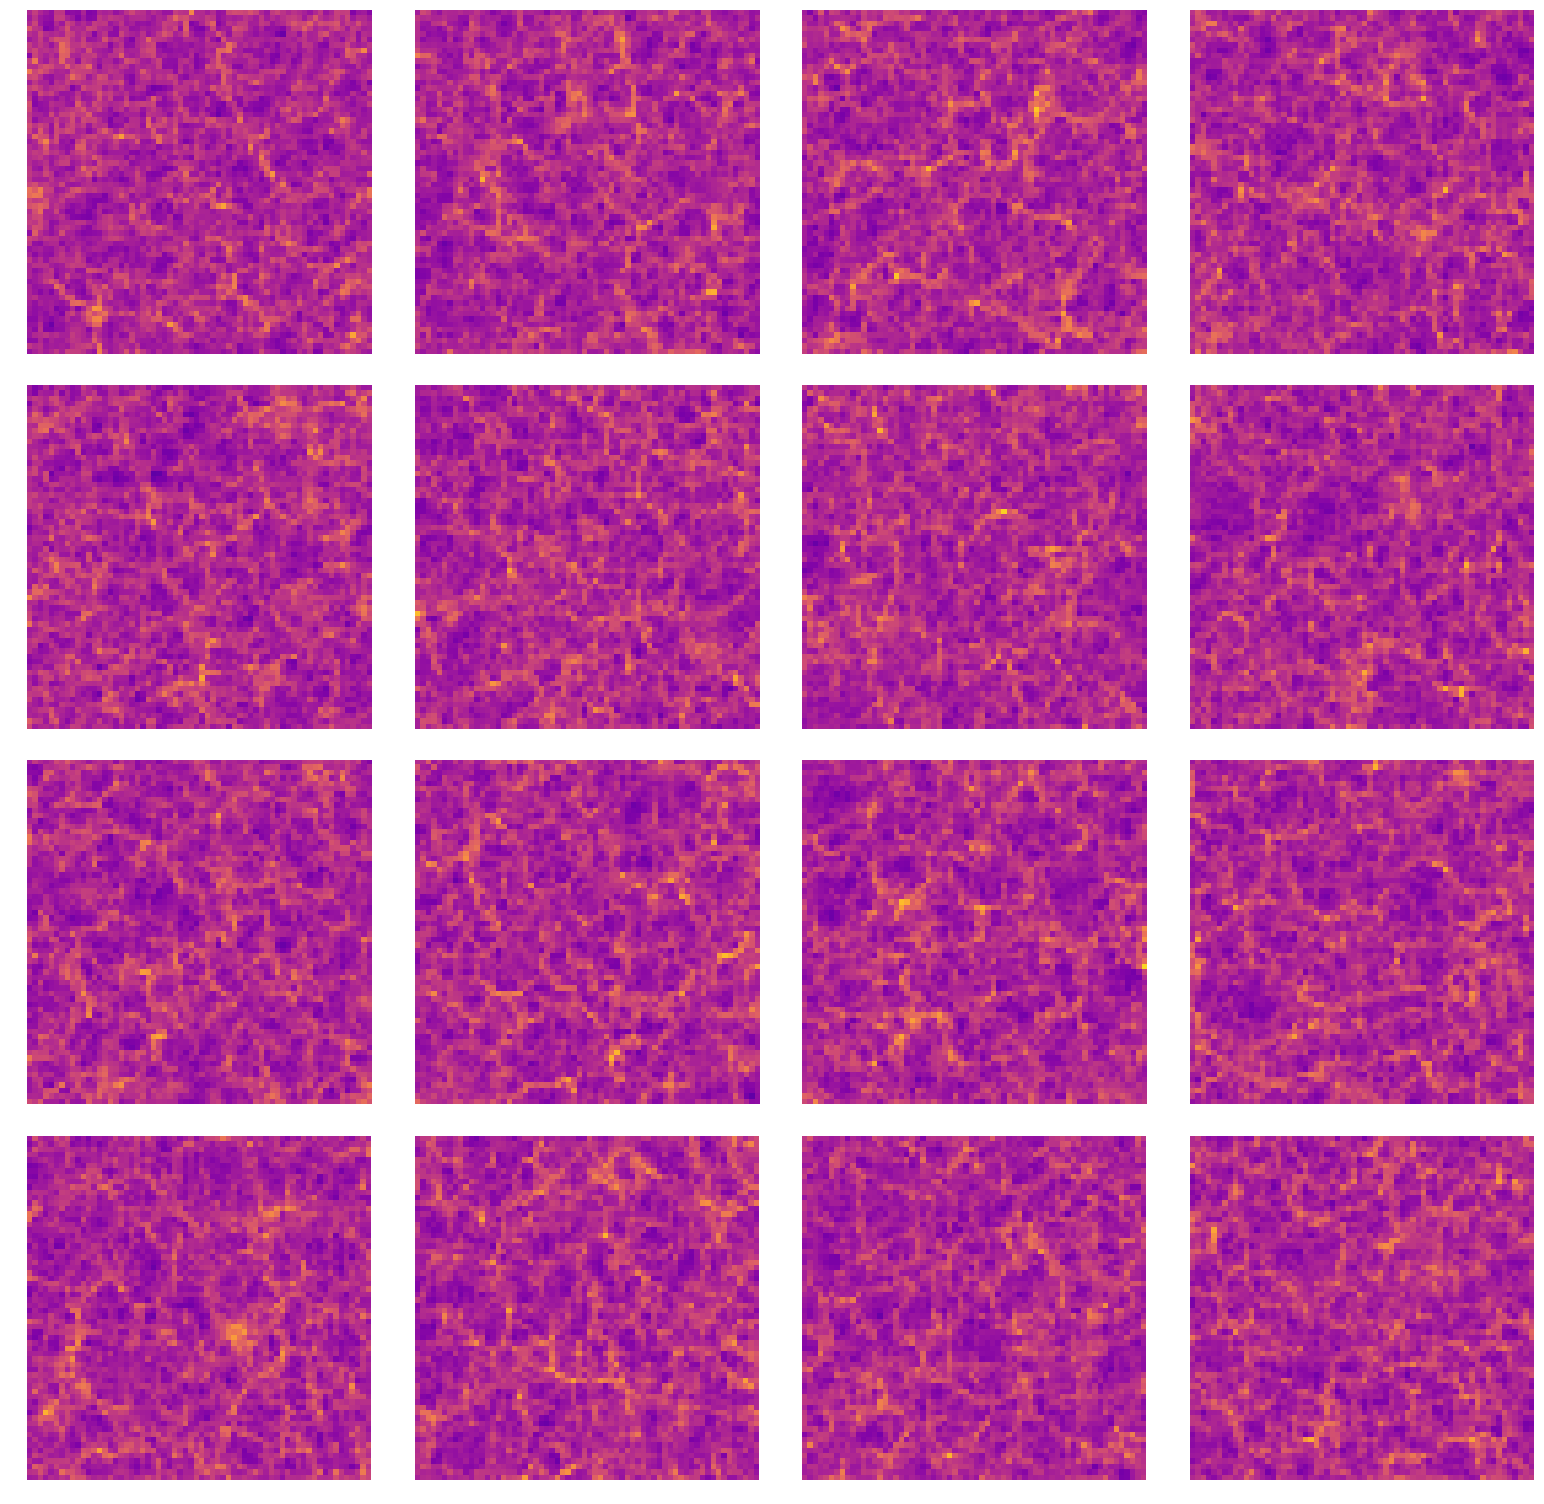

In [68]:
cmin = 0
cmax = 2.5
clim = (cmin, cmax)
plot_cubes_paper(gen_samples_64, cmap=plt.cm.plasma, clim=clim, nx=4, ny=4);


## 64->256

In [69]:
gen_samples_64 = utils.load_hdf5(os.path.join(pathsample,'ankit_32_64/64_samples_ckpt_latest.h5'))

print('gen_samples_64 shape=', gen_samples_64.shape)
gen_samples_64 = np.expand_dims(gen_samples_64, axis=4)[:num_samples]
print('downsampled shape=', gen_samples_64.shape)

gen_samples_64 shape= (30, 64, 64, 64)
downsampled shape= (30, 64, 64, 64, 1)


In [70]:
name = 'WGAN_ankit_64_to_256_checkpoints'
checkpoint256 = None
# checkpoint256 = 150000 
pathmodel256 = os.path.join(pathmodel, name)

params_256 = utils.load_params(pathmodel256)


In [71]:
wgan_256 = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_256)
gen_samples_256 = wgan_256.upscale_image(small=gen_samples_64, checkpoint=checkpoint256)

Generator 
--------------------------------------------------
     The input is of size (?, 32768)
     Reshape to (?, 32, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 32, 9)
     0 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     1 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     2 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Residual connection
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     3 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     4 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Residual connection
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     5 Inception conv(1x1,3x3,5x5) layer wit

Checkpoint successfully loaded!
Total number of patches = 8*8*8 = 512
Current patch: column=1, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=6, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=7, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=8, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=2, height=1

Sampling z
Not loading a check

Current patch: column=2, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=3, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=4, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=5, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=6, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=7, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=8, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=1, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=2, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=3, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=4, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=5, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=6, row=7, height=2

Sampling z
Not loading

Current patch: column=4, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=1, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=2, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=3, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=4, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=4, height=4

Sampling z
Not loading

Current patch: column=6, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=7, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=8, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=6, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=7, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=8, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=6

Sampling z
Not loading

Current patch: column=8, row=5, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=2, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=3, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=4, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=5, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=6, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=7, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=8, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=2, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=3, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=4, row=7, height=7

Sampling z
Not loading

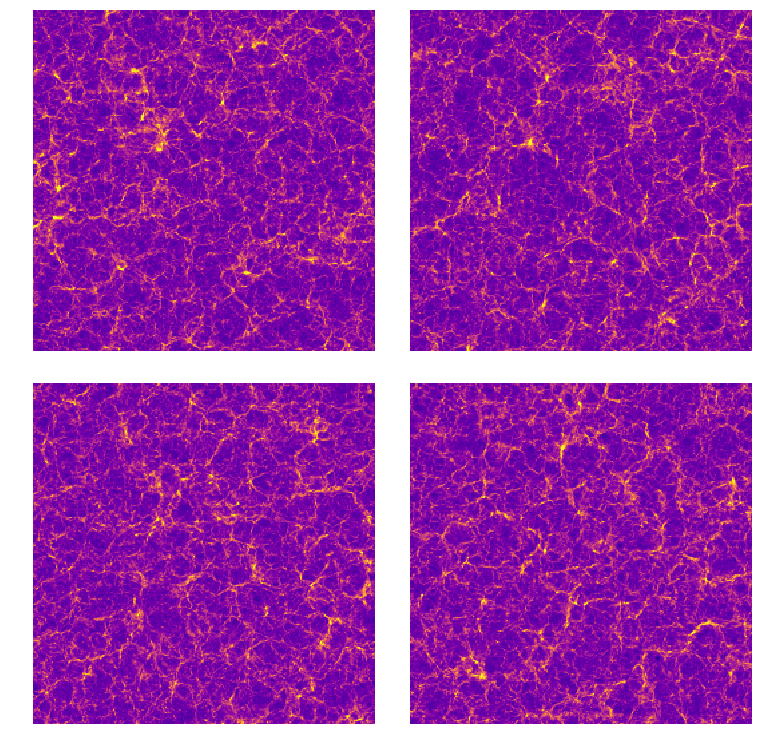

In [72]:
cmin = 0
cmax = 3.5
clim = (cmin, cmax)
plot_cubes_paper(gen_samples_256, cmap=plt.cm.plasma, clim=clim, nx=2, ny=2);

In [73]:
os.makedirs(os.path.join(pathsample,'ankit_64_256/'), exist_ok=True)
utils.save_hdf5(gen_samples_256, os.path.join(pathsample,'ankit_64_256/256_samples_ckpt_latest.h5'))

# Uniscale model
This is not working. There is a special branch for this model.

In [20]:
name = name = 'WGAN_ankit_uniscale_checkpoints'
checkpointuniscale = None
# checkpointuniscale = 178000

pathmodel_uniscale = os.path.join(pathmodel, name)
params_uniscale = utils.load_params(pathmodel_uniscale)
class CosmoUpscalePatchWGAN(UpscalePatchWGAN, CosmoWGAN):
    pass
params_uniscale['upscaling']=None



In [21]:
wgan_uniscale = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_uniscale)
gen_samples_uniscale = wgan_uniscale.upscale_image(N=num_samples, resolution=256, checkpoint=checkpointuniscale)

Generator 
--------------------------------------------------
     The input is of size (?, 32768)
     Reshape to (?, 32, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 32, 8)
     0 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 96)
     1 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 96)
     2 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 192)
     3 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 192)
     4 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 192)
     5 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applie

Checkpoint successfully loaded!
Total number of patches = 8*8*8 = 512
Current patch: column=1, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=6, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=7, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=8, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=2, height=1

Sampling z
Not loading a check

Current patch: column=2, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=3, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=4, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=5, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=6, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=7, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=8, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=1, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=2, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=3, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=4, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=5, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=6, row=7, height=2

Sampling z
Not loading

Current patch: column=4, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=1, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=2, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=3, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=4, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=4, height=4

Sampling z
Not loading

Current patch: column=6, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=7, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=8, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=6, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=7, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=8, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=6

Sampling z
Not loading

Current patch: column=8, row=5, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=2, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=3, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=4, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=5, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=6, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=7, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=8, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=2, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=3, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=4, row=7, height=7

Sampling z
Not loading

In [22]:
os.makedirs(os.path.join(pathsample,'ankit_uniscale/'), exist_ok=True)
utils.save_hdf5(gen_samples_uniscale, os.path.join(pathsample,'ankit_uniscale/256_samples_ckpt_latest.h5'))

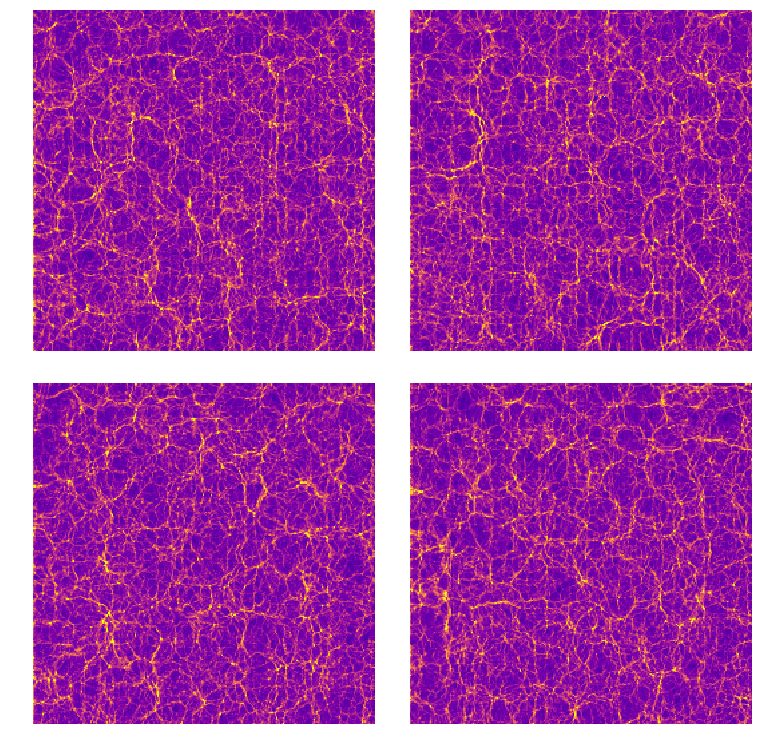

In [23]:
cmin = 0
cmax = 3
clim = (cmin, cmax)
plot_cubes_paper(gen_samples_uniscale, cmap=plt.cm.plasma, clim=clim, nx=2, ny=2);

# Make the figures for the paper

In [24]:
pathfig = 'figures/'
os.makedirs(pathfig, exist_ok=True)

#### Load all samples

In [74]:
gen_samples_32 = utils.load_hdf5(os.path.join(pathsample,'ankit_0_32/32_samples_ckpt_latest.h5'))
gen_samples_64 = utils.load_hdf5(os.path.join(pathsample,'ankit_32_64/64_samples_ckpt_latest.h5'))
gen_samples_256 = utils.load_hdf5(os.path.join(pathsample,'ankit_64_256/256_samples_ckpt_latest.h5'))
gen_samples_uniscale = utils.load_hdf5(os.path.join(pathsample,'ankit_uniscale/256_samples_ckpt_latest.h5'))


#### Backward transform

In [75]:
gen_samples_32_raw = backward(gen_samples_32)
gen_samples_64_raw = backward(gen_samples_64)
gen_samples_256_raw = backward(gen_samples_256)
gen_samples_uniscale_raw = backward(gen_samples_uniscale)


#### Load real data

In [27]:
dataset256 = data.load.load_nbody_dataset(resolution=256,Mpch=350,shuffle=False,forward_map=forward,spix=256,patch=False,is_3d=True,augmentation=False)
real_samples_256 = dataset256.get_all_data()
del dataset256


images shape =  (30, 256, 256, 256)


In [28]:
real_samples_256_raw = backward(real_samples_256)

In [29]:
dataset32 = data.load.load_nbody_dataset(resolution=256,Mpch=350,shuffle=False,forward_map=forward,spix=32,patch=False,is_3d=True,augmentation=False, scaling=8)
real_samples_32 = dataset32.get_all_data()
del dataset32

images shape =  (30, 256, 256, 256)


In [30]:
real_samples_32_raw = backward(real_samples_32)

In [31]:
dataset64 = data.load.load_nbody_dataset(resolution=256,Mpch=350,shuffle=False,forward_map=forward,spix=64,patch=False,is_3d=True,augmentation=False, scaling=4)
real_samples_64 = dataset64.get_all_data()
del dataset64

images shape =  (30, 256, 256, 256)


In [32]:
real_samples_64_raw = backward(real_samples_64)

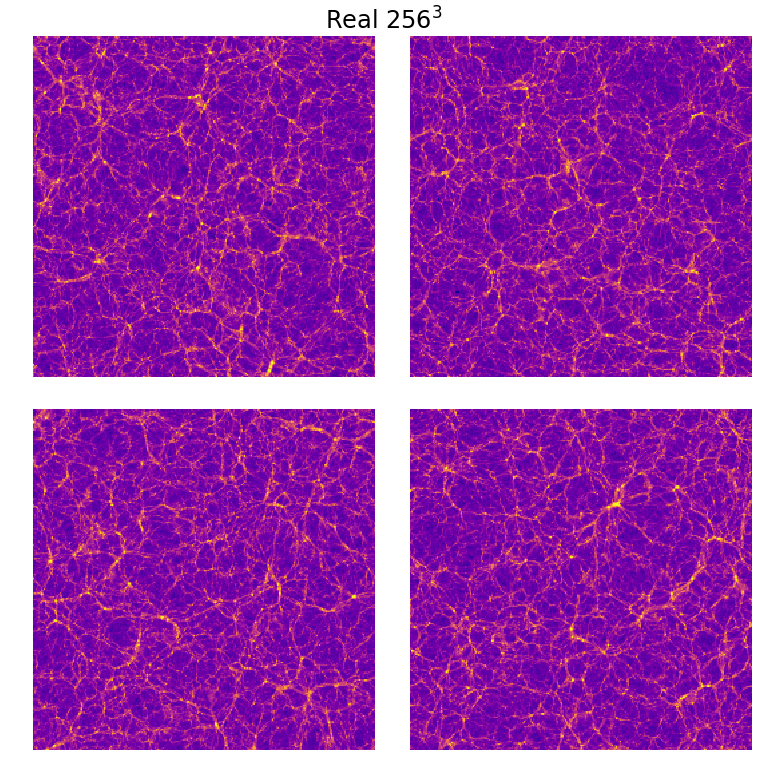

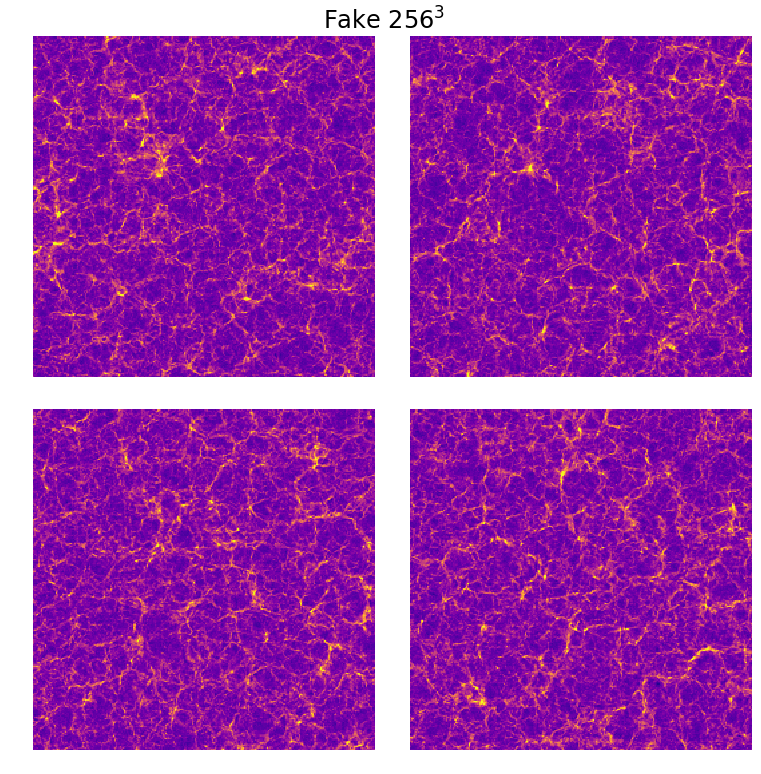

In [76]:
# cmin = np.min(cubes)
# cmax = np.max(cubes)/1.5
cmin = 0
cmax = 3.5
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_256, cmap=plt.cm.plasma, clim=clim);
fig.suptitle('Real $256^3$', y=1.02, fontsize=24 )
plt.savefig(pathfig+"real256.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_256, cmap=plt.cm.plasma, clim=clim);
fig2.suptitle('Fake $256^3$', y=1.02, fontsize=24 )
plt.savefig(pathfig+"fake256.pdf", bbox_inches='tight', format='pdf')



Log l2 Mass histogram loss: 44.21305049679225
L2 Peak Mass histogram: 21228178879.894424
Log l1 Mass histogram loss: 2.6900790257898692
L1 Mass histogram loss: 59877.563333333295


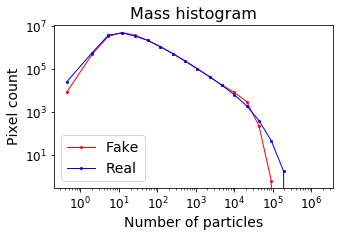

In [77]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_256_raw, gen_samples_256_raw)
plt.savefig(pathfig+"256full_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 73.53238643515026
L2 Peak Count loss: 350854.5937222222
Log l1 Peak Count loss: 4.144470194835835
L1 Peak Count loss: 430.91166666666675


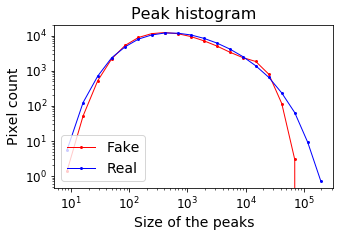

In [78]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_256_raw, gen_samples_256_raw)
plt.savefig(pathfig+"256full_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 0.46387777645436595
L2 PSD loss: 25002.844184951253
Log l1 PSD loss: 0.45794154771920115
L1 PSD loss: 61.061912373695584


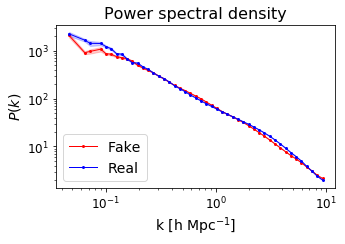

In [79]:
evaluation.compute_and_plot_psd(real_samples_256_raw, gen_samples_256_raw)
plt.savefig(pathfig+"256full_psd.pdf", bbox_inches='tight', format='pdf')

# Scale by scale analysis

## 32 cubes

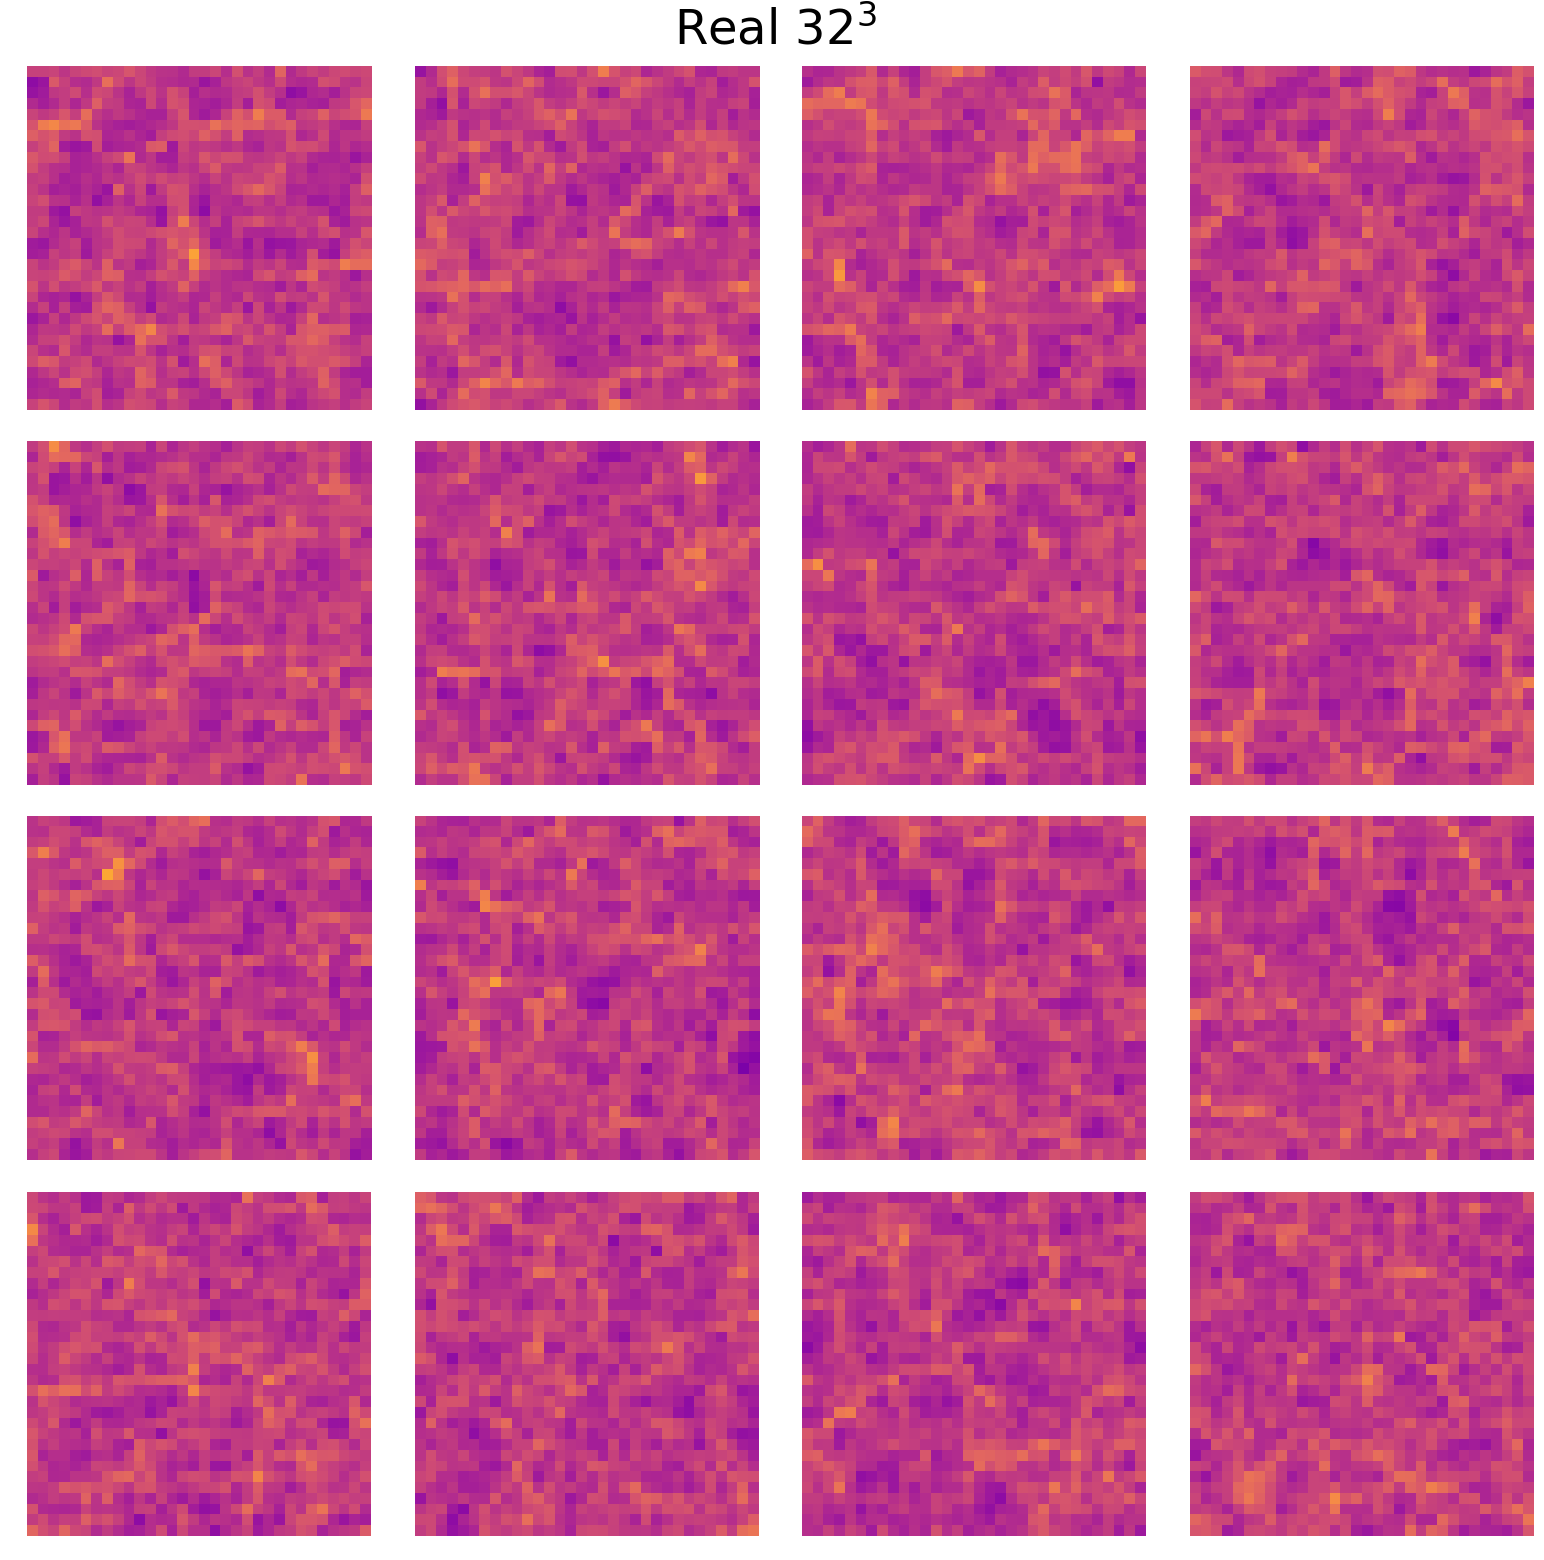

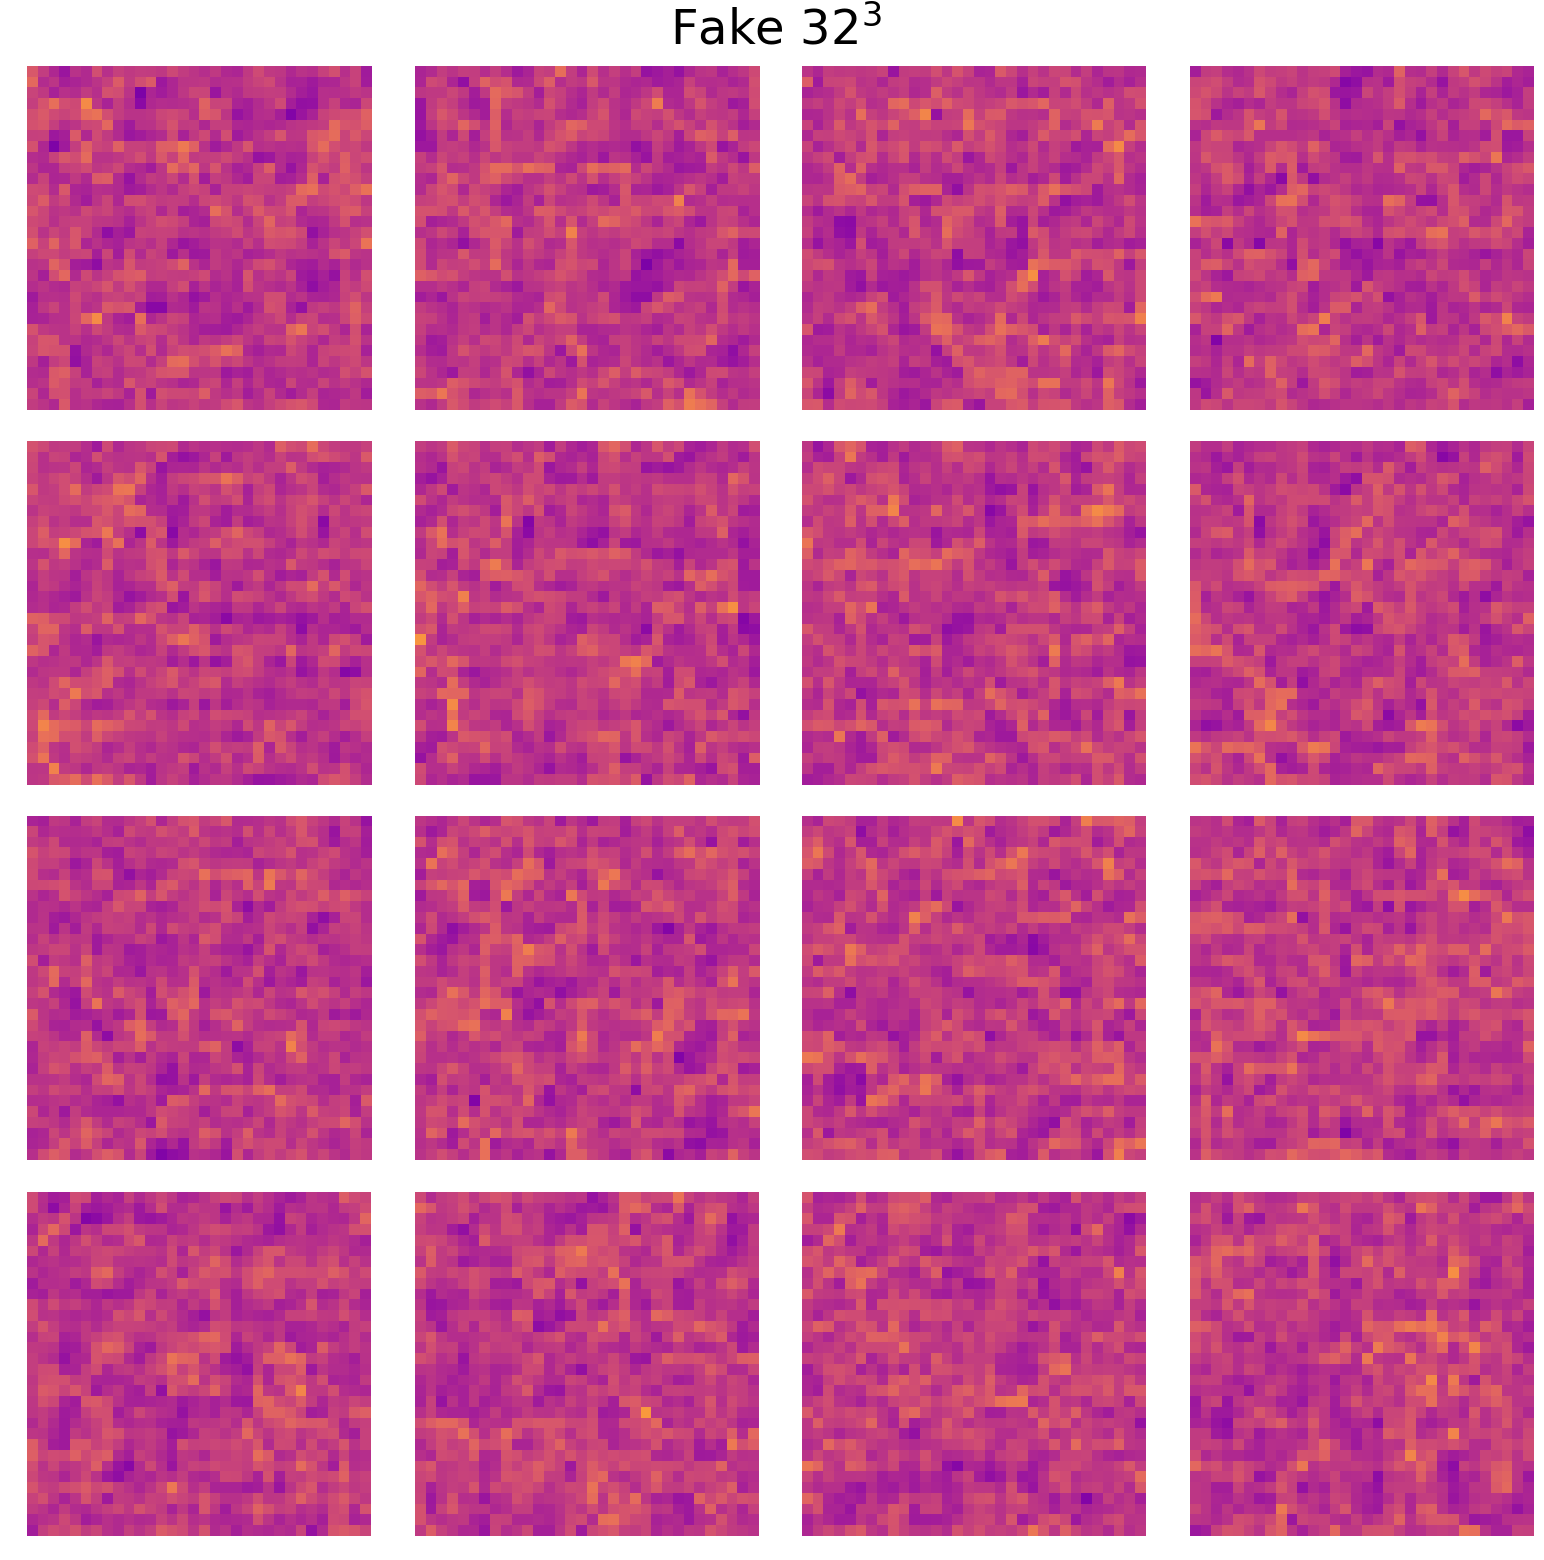

In [37]:
# cmin = np.min(cubes_32)
# # cmin = 0
# cmax = np.max(cubes_32)
cmin = 0.1
cmax = 2
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_32, cmap=plt.cm.plasma, clim=clim, nx=4, ny=4);
fig.suptitle('Real $32^3$', y=1.03, fontsize=48 )
plt.savefig(pathfig+"real32.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_32, cmap=plt.cm.plasma, clim=clim, nx=4, ny=4);
fig2.suptitle('Fake $32^3$', y=1.03, fontsize=48 )
plt.savefig(pathfig+"fake32.pdf", bbox_inches='tight', format='pdf')



Log l2 Mass histogram loss: 14.58061818009528
L2 Peak Mass histogram: 28418.951722222213
Log l1 Mass histogram loss: 1.9633362183732657
L1 Mass histogram loss: 87.32833333333335


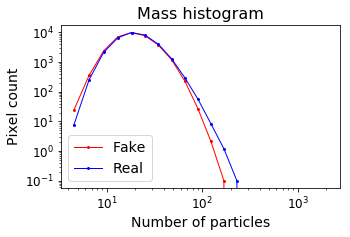

In [38]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_32_raw, gen_samples_32_raw)
plt.savefig(pathfig+"32_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 29.524992920755892
L2 Peak Count loss: 14.211388888888887
Log l1 Peak Count loss: 3.8223602631586444
L1 Peak Count loss: 2.661666666666666


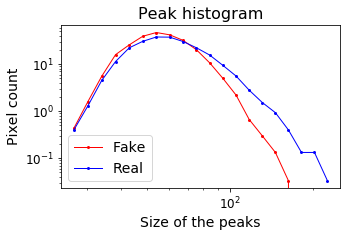

In [39]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_32_raw, gen_samples_32_raw)
plt.savefig(pathfig+"32_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 0.9587322211803949
L2 PSD loss: 2430.914011021382
Log l1 PSD loss: 0.7040394753159295
L1 PSD loss: 28.42795191332986


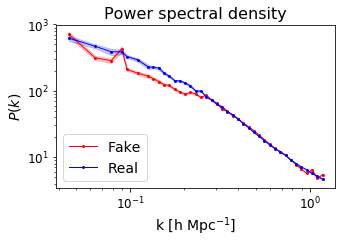

In [40]:
evaluation.compute_and_plot_psd(real_samples_32_raw, gen_samples_32_raw)
plt.savefig(pathfig+"32_psd.pdf", bbox_inches='tight', format='pdf')

## 64 Cubes

In [41]:
name = 'WGAN_ankit_32_to_64_checkpoints'
class CosmoUpscalePatchWGAN(UpscalePatchWGAN, CosmoWGAN):
    pass
pathmodel64 = os.path.join(pathmodel, name)
params_64 = utils.load_params(pathmodel64)
wgan_64 = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_64)
gen_samples_64_single = wgan_64.upscale_image(small=np.reshape(real_samples_32, [*real_samples_32.shape,1]), checkpoint=checkpoint64)

Generator 
--------------------------------------------------
     The input is of size (?, 32768)
     Reshape to (?, 32, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 32, 9)
     0 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     1 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     2 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Residual connection
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     3 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     4 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Residual connection
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     5 Inception conv(1x1,3x3,5x5) layer wit

Checkpoint successfully loaded!
Total number of patches = 2*2*2 = 8
Current patch: column=1, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=2

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=2

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=2

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=2

Sampling z
Not loading a checkpoint


In [42]:
gen_samples_64_single_raw = backward(gen_samples_64_single)

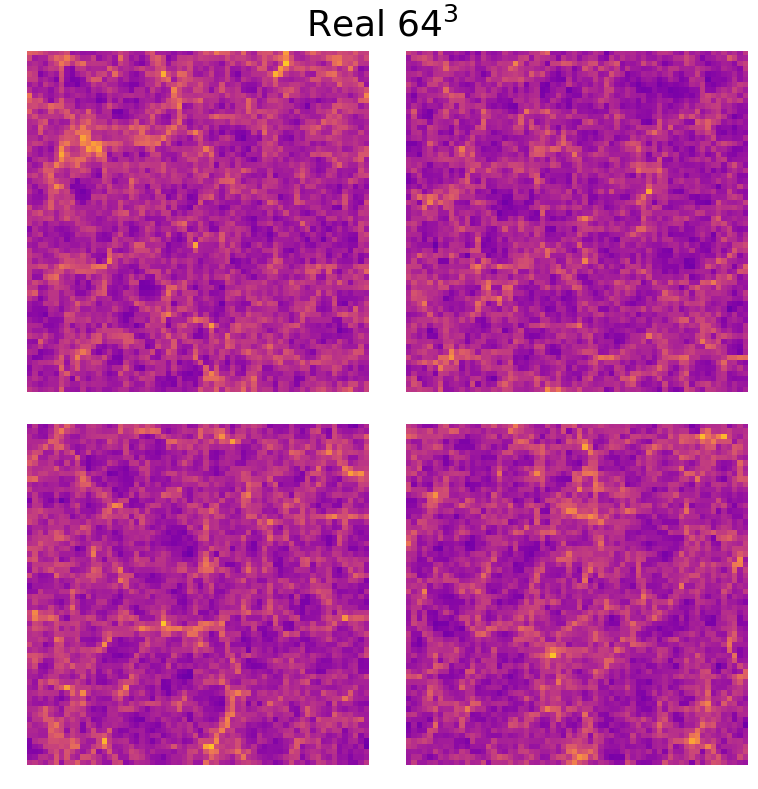

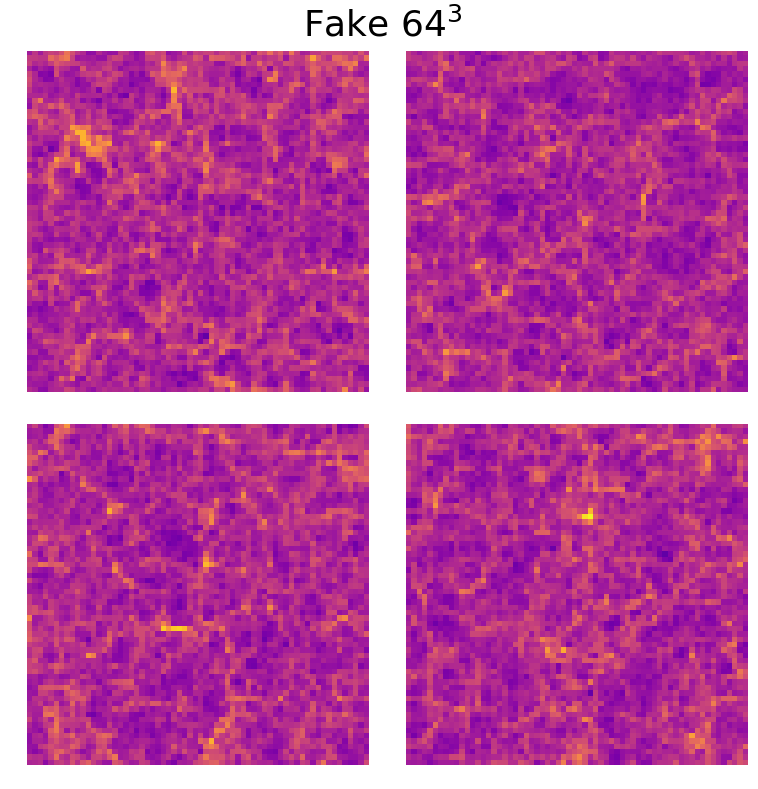

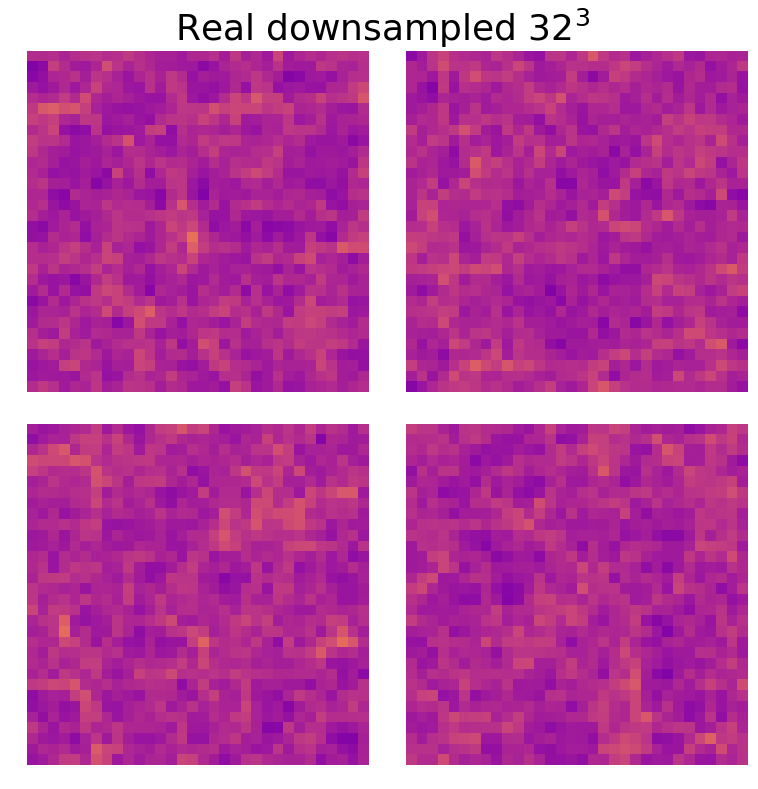

In [43]:
# cmin = np.min(cubes_64)
# cmax = np.max(cubes_64)
cmin = 0
cmax = 2.5
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_64, cmap=plt.cm.plasma, clim=clim);
fig.suptitle('Real $64^3$', y=1.04, fontsize=36 )
plt.savefig(pathfig+"up_real64.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_64_single, cmap=plt.cm.plasma, clim=clim);
fig2.suptitle('Fake $64^3$', y=1.04, fontsize=36 )
plt.savefig(pathfig+"up_fake64.pdf", bbox_inches='tight', format='pdf')

fig = plot_cubes_paper(real_samples_32, cmap=plt.cm.plasma, clim=clim);
fig.suptitle('Real downsampled $32^3$', y=1.04, fontsize=36 )
plt.savefig(pathfig+"up_down32.pdf", bbox_inches='tight', format='pdf')

Log l2 Mass histogram loss: 10.14784474736653
L2 Peak Mass histogram: 769266.4771666673
Log l1 Mass histogram loss: 1.756617722470979
L1 Mass histogram loss: 481.9416666666668


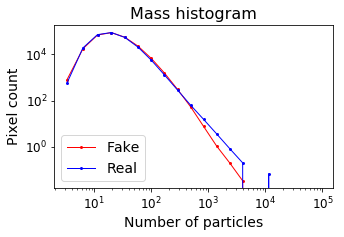

In [44]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_64_raw, gen_samples_64_single_raw)
plt.savefig(pathfig+"up_64_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 15.147550633268896
L2 Peak Count loss: 399.4377777777779
Log l1 Peak Count loss: 2.8649339710234214
L1 Peak Count loss: 10.856666666666666


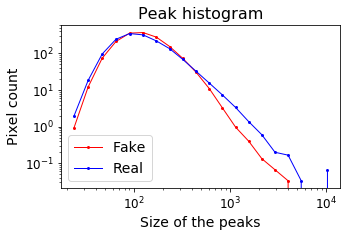

In [45]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_64_raw, gen_samples_64_single_raw)
plt.savefig(pathfig+"up_64_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 0.6975837426644338
L2 PSD loss: 2532.4904560745404
Log l1 PSD loss: 0.6133795720389755
L1 PSD loss: 19.744183095491536


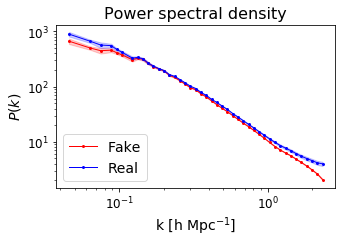

In [46]:
evaluation.compute_and_plot_psd(real_samples_64_raw, gen_samples_64_single_raw)
plt.savefig(pathfig+"up_64_psd.pdf", bbox_inches='tight', format='pdf')

## 256 Cubes

In [47]:
name = 'WGAN_ankit_64_to_256_checkpoints'
pathmodel256 = os.path.join(pathmodel, name)

params_256 = utils.load_params(pathmodel256)

wgan_256 = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_256)
gen_samples_single_256 = wgan_256.upscale_image(small=np.reshape(real_samples_64, [*real_samples_64.shape, 1]), checkpoint=checkpoint256)

Generator 
--------------------------------------------------
     The input is of size (?, 32768)
     Reshape to (?, 32, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 32, 9)
     0 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     1 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     2 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Residual connection
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     3 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     4 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Residual connection
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 32)
     5 Inception conv(1x1,3x3,5x5) layer wit

Checkpoint successfully loaded!
Total number of patches = 8*8*8 = 512
Current patch: column=1, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=6, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=7, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=8, row=1, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=2, height=1

Sampling z
Not loading a check

Current patch: column=2, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=3, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=4, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=5, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=6, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=7, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=8, row=6, height=2

Sampling z
Not loading a checkpoint
Current patch: column=1, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=2, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=3, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=4, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=5, row=7, height=2

Sampling z
Not loading a checkpoint
Current patch: column=6, row=7, height=2

Sampling z
Not loading

Current patch: column=4, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=3, height=4

Sampling z
Not loading a checkpoint
Current patch: column=1, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=2, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=3, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=4, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=4, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=4, height=4

Sampling z
Not loading

Current patch: column=6, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=7, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=8, row=8, height=5

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=6, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=7, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=8, row=1, height=6

Sampling z
Not loading a checkpoint
Current patch: column=1, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=2, height=6

Sampling z
Not loading

Current patch: column=8, row=5, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=2, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=3, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=4, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=5, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=6, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=7, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=8, row=6, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=2, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=3, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=4, row=7, height=7

Sampling z
Not loading

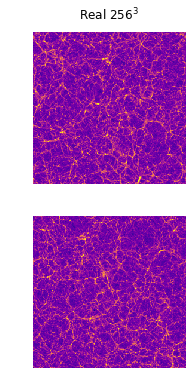

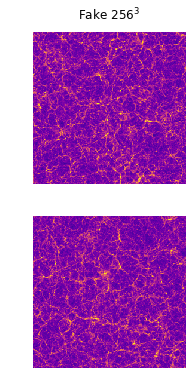

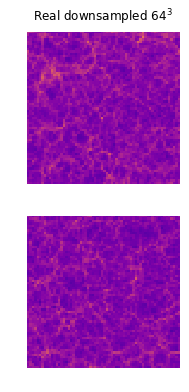

In [48]:
# cmin = np.min(cubes_256)
# cmax = np.max(cubes_256)/2.5
cmin = 0
cmax = 3.5
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_256, cmap=plt.cm.plasma, clim=clim, ny=1);
fig.suptitle('Real $256^3$', y=1.03, fontsize=12 )
plt.savefig(pathfig+"up_real256.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_single_256, cmap=plt.cm.plasma, clim=clim, ny=1);
fig2.suptitle('Fake $256^3$', y=1.03, fontsize=12 )
plt.savefig(pathfig+"up_fake256.pdf", bbox_inches='tight', format='pdf')

fig = plot_cubes_paper(real_samples_64, cmap=plt.cm.plasma, clim=clim, ny=1);
fig.suptitle('Real downsampled $64^3$', y=1.03, fontsize=12 )
plt.savefig(pathfig+"up_down64.pdf", bbox_inches='tight', format='pdf')

In [49]:
gen_samples_single_256_raw = backward(gen_samples_single_256)

Log l2 Mass histogram loss: 36.723022649197326
L2 Peak Mass histogram: 13882066981.00708
Log l1 Mass histogram loss: 2.492581493668896
L1 Mass histogram loss: 58288.61333333327


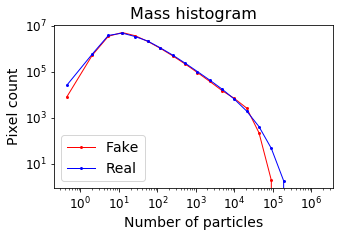

In [50]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_256_raw, gen_samples_single_256_raw)
plt.savefig(pathfig+"up_256_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 47.25587716752051
L2 Peak Count loss: 658219.9517777776
Log l1 Peak Count loss: 3.3817663614532663
L1 Peak Count loss: 558.5133333333335


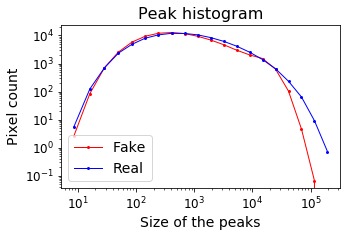

In [51]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_256_raw, gen_samples_single_256_raw)
plt.savefig(pathfig+"up_256_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 0.26878609467483683
L2 PSD loss: 8953.45661066533
Log l1 PSD loss: 0.48414534585591407
L1 PSD loss: 50.000780537247785


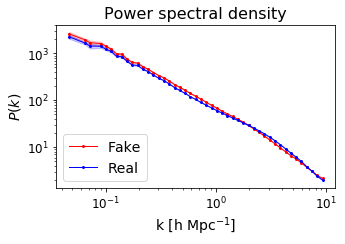

In [52]:
evaluation.compute_and_plot_psd(real_samples_256_raw, gen_samples_single_256_raw)
plt.savefig(pathfig+"up_256_psd.pdf", bbox_inches='tight', format='pdf')

## Uniscale

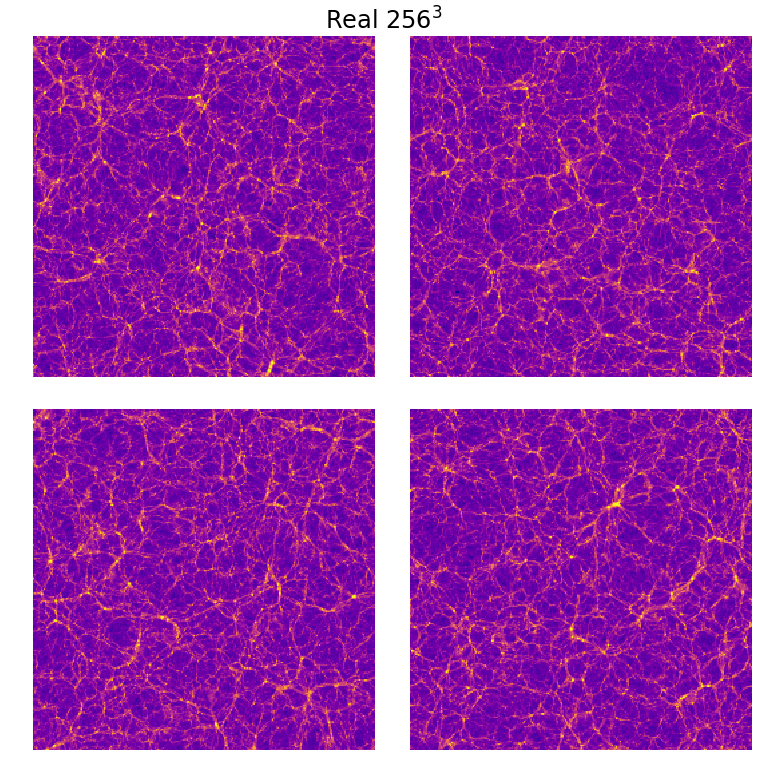

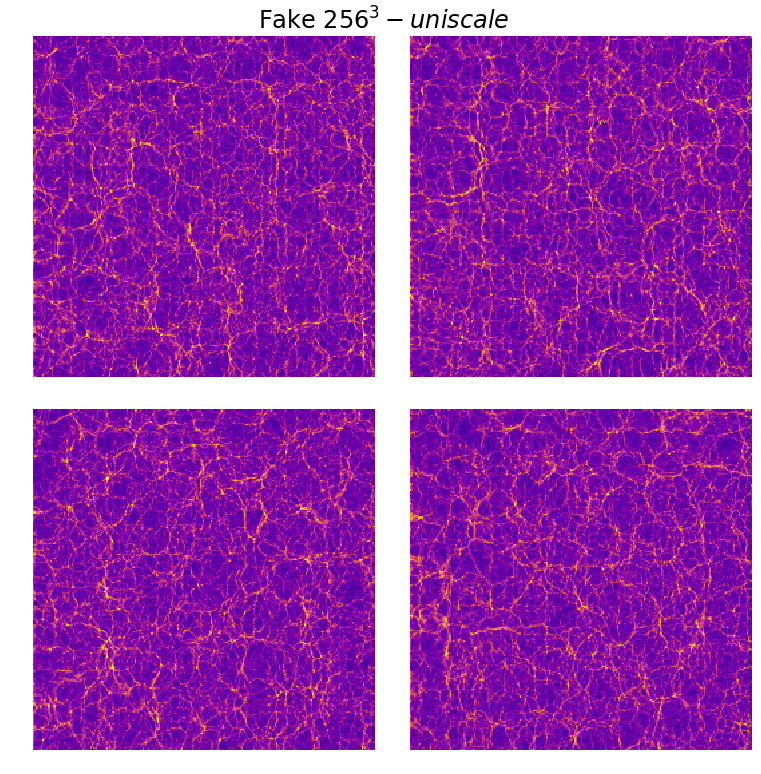

In [53]:
cmin = 0
cmax = 3.5
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_256, cmap=plt.cm.plasma, clim=clim);
fig.suptitle('Real $256^3$', y=1.02, fontsize=24 )
plt.savefig(pathfig+"uniscalereal256.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_uniscale, cmap=plt.cm.plasma, clim=clim);
fig2.suptitle('Fake $256^3 - uniscale$', y=1.02, fontsize=24 )
plt.savefig(pathfig+"uniscalefake256.pdf", bbox_inches='tight', format='pdf')

Log l2 Mass histogram loss: 43.696083380184035
L2 Peak Mass histogram: 3899995596.7602715
Log l1 Mass histogram loss: 2.6016731823930677
L1 Mass histogram loss: 31161.608333333315


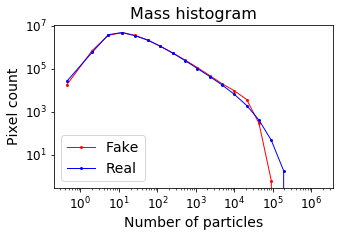

In [54]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_256_raw, gen_samples_uniscale_raw)
plt.savefig(pathfig+"256uniscale_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 69.93493219932785
L2 Peak Count loss: 142576.4992777778
Log l1 Peak Count loss: 3.661004173309847
L1 Peak Count loss: 259.2616666666666


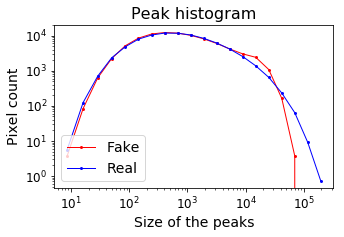

In [55]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_256_raw, gen_samples_uniscale_raw)
plt.savefig(pathfig+"256uniscale_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 1.9946653659446127
L2 PSD loss: 135450.81022349602
Log l1 PSD loss: 0.9496491744302322
L1 PSD loss: 150.52256393788554


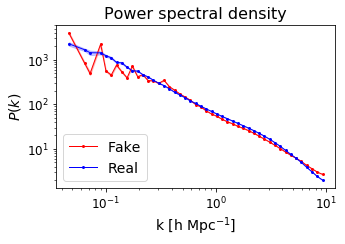

In [56]:
evaluation.compute_and_plot_psd(real_samples_256_raw, gen_samples_uniscale_raw)
plt.savefig(pathfig+"256uniscale_psd.pdf", bbox_inches='tight', format='pdf')

# Gifs

## Real 256 cubes

In [57]:
# fps=16
# clim = (0,3)
# plot.animate_cubes(real_samples_256, output_name=pathfig+"real256.gif", clim=clim, fps=fps, cmap=plt.cm.plasma)
# animation = plot.cubes_to_animation(real_samples_256, cmap=plt.cm.plasma, clim=clim)
# animation.ipython_display(fps=16, loop=True, autoplay=True)


In [58]:
# plot.save_animation(real_samples_256[0], gen_samples_256[0], figsize=(10, 6), fps=16, format='mp4', output_file_name=pathfig+'final.mp4', clim=clim)
# plt.style.use('ggplot')